<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Полезные-ссылки:" data-toc-modified-id="Полезные-ссылки:-0.0.1"><span class="toc-item-num">0.0.1&nbsp;&nbsp;</span><font color="orange">Полезные ссылки:</font></a></span></li></ul></li><li><span><a href="#Общее-впечатление" data-toc-modified-id="Общее-впечатление-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><font color="orange">Общее впечатление</font></a></span></li><li><span><a href="#Общее-впечатление-(ревью-2)" data-toc-modified-id="Общее-впечатление-(ревью-2)-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span><font color="orange">Общее впечатление (ревью 2)</font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Проверка-стационарности" data-toc-modified-id="Проверка-стационарности-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Проверка стационарности</a></span></li><li><span><a href="#Сезонные-переменные" data-toc-modified-id="Сезонные-переменные-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Сезонные переменные</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Константная-модель" data-toc-modified-id="Константная-модель-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Константная модель</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Линейная-регрессия-с-подбором-гиперпараметров" data-toc-modified-id="Линейная-регрессия-с-подбором-гиперпараметров-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Линейная регрессия с подбором гиперпараметров</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [100]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [101]:
#загрузим данные
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.info()
#проверим, что данные расположены по порядку
print('Данные расположены корректно:', df.index.is_monotonic)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
Данные расположены корректно: True


In [102]:
display(df.head())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [103]:
#ресемплируем ряд к интервалу в 1 час
df = df.resample('1H').sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


**Вывод**   
Итоговая выборка содержит 4,416 наблюдений по часам с марта по август 2018 года.

## Анализ

### Проверка стационарности

Рассмотрим график временного ряда.

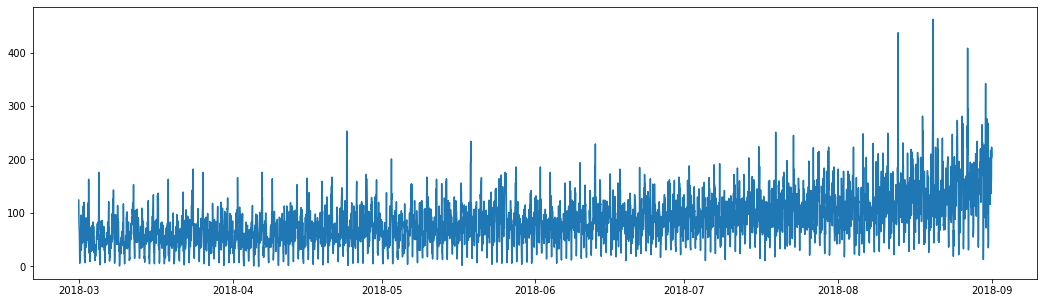

In [104]:
plt.figure(figsize=(18,5))
plt.plot(df)
plt.show()

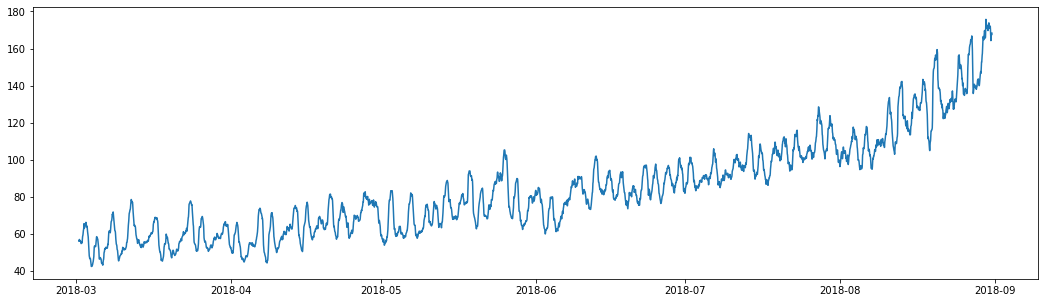

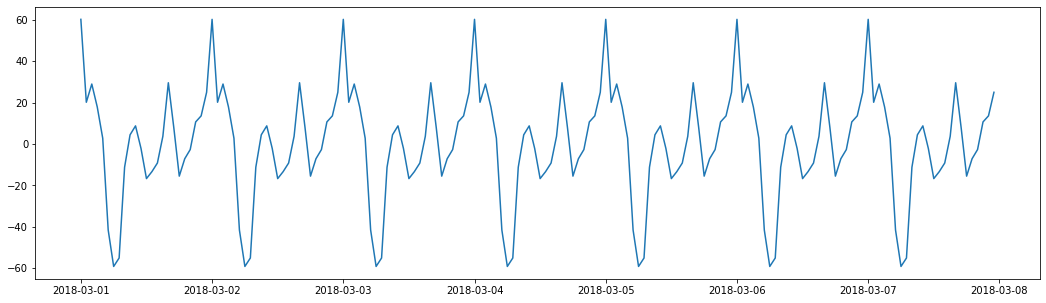

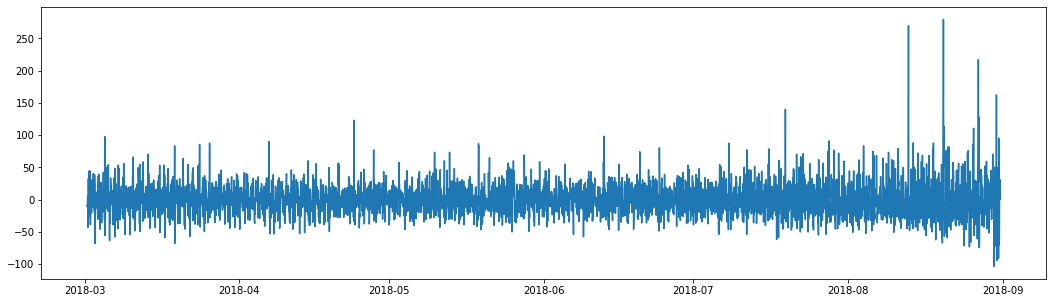

In [105]:
# разложим ряд на составляющие
decomposed = seasonal_decompose(df)

plt.figure(figsize=(18,5))
plt.plot(decomposed.trend)
plt.show()

plt.figure(figsize=(18,5))
plt.plot(decomposed.seasonal['2018-03-01':'2018-03-07'])
plt.show()

plt.figure(figsize=(18,5))
plt.plot(decomposed.resid)
plt.show()

Заметно увеличение как среднего (возрастающая линия тренда), так и дисперсии (возрастающий разброс остатков). Проверим стационарность критерием Дики-Фуллера.

In [106]:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(df['num_orders'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   -3.068924
p-value                           0.028940
#Lags Used                       30.000000
Number of Observations Used    4385.000000
dtype: float64


p-value меньше критического уровня в 5% => отвергаем нулевую гипотезу о нестационарности ряда.

**Вывод**   
Критерий Дики-Фуллера свидетельствует о стационарности ряда, при этом на графиках видны как растущий тренд, так и увеличивающийся разброс, сопровождающийся суточной сезонностью.

### Сезонные переменные

Проверим, есть ли сезонная зависимость в течение месяца, недели, суток.

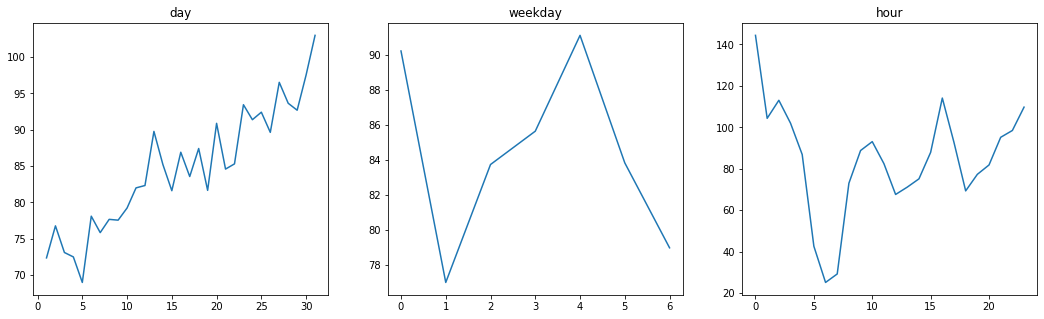

In [107]:
df['day'] = df.index.day
df['weekday'] = df.index.dayofweek
df['hour'] = df.index.hour
lst = ['day', 'weekday', 'hour']

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
i = 0
for element in lst:
    pivot = df.pivot_table(index=element, aggfunc='mean', values='num_orders')
    ax[i].plot(pivot)
    ax[i].title.set_text(element)
    i += 1

**Вывод**   
Среднее по дням отражает общую тенденцию к увеличению кол-ва заказов, при этом видно, что среднее кол-во заказов сильно различается по дням недели и часам => эти переменные нужно использовать как dummy в дальнейшем анализе.

## Обучение

In [108]:
#выделим даты как переменные для отражения сезонности
lst_dummies = ['weekday', 'hour']
df = pd.get_dummies(df, columns = lst_dummies)

In [109]:
# создание объясняющих переменных
def features_define(df, shift, rolling_mean_size):
    df_mod = df.copy()
    for k in range(1, shift+1):
        df_mod[f'lag_{k}'] = df_mod['num_orders'].shift(k)
    df_mod['ma'] = df_mod['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df_mod

### Константная модель

In [110]:
# разделим выборки
train, test = train_test_split(df, shuffle=False, test_size=0.1)
# разделим переменные
target_train = train['num_orders']
target_test = test['num_orders']
features_train = train.drop('num_orders', axis=1)
features_test = train.drop('num_orders', axis=1)
# оценим модель
predicted = np.ones(len(target_test))*target_test.mean()
mse = mean_squared_error(target_test, predicted)
rmse = mse ** 0.5
print(f'rmse: {rmse:.2f}')

rmse: 58.55


### Линейная регрессия

In [111]:
# оценим модель     
model = LinearRegression()
tscv = TimeSeriesSplit(n_splits=5)
cvs = cross_val_score(model, features_train, target_train, cv=tscv, scoring='neg_root_mean_squared_error')
rmse = - np.mean(cvs)
print(f'rmse: {rmse:.2f}')

rmse: 32.52


### Линейная регрессия с подбором гиперпараметров

In [112]:
# перебор моделей
rmse_min = 1000
shift_best = 0
rolling_best = 0

for s in range(1, 30):
    for r in range(1, 10):
        df_mod = features_define(df, s, r)
# разделим выборки
        df_mod = df_mod.dropna()
        train, test = train_test_split(df_mod, shuffle=False, test_size=0.1)
# разделим переменные
        target_train = train['num_orders']
        target_test = test['num_orders']
        features_train = train.drop('num_orders', axis=1)
        features_test = test.drop('num_orders', axis=1)
# оценим модель     
        model = LinearRegression()
        tscv = TimeSeriesSplit(n_splits=5)
        cvs = cross_val_score(model, features_train, target_train, cv=tscv, scoring='neg_root_mean_squared_error')
        rmse = - np.mean(cvs)
        if rmse < rmse_min:
            rmse_min = rmse
            shift_best = s
            rolling_best = r

print(f'Лучшая модель: shift = {shift_best}, rolling_mean_size = {rolling_best}, rmse:{rmse_min:.2f}')

Лучшая модель: shift = 28, rolling_mean_size = 9, rmse:25.37


**Вывод**   
Модель с подбором гиперпараметров показала значительно лучшие результаты. Проанализируем результаты на тестовой выборке.

## Тестирование

shift = 28, rolling_mean_size = 9, rmse:41.98


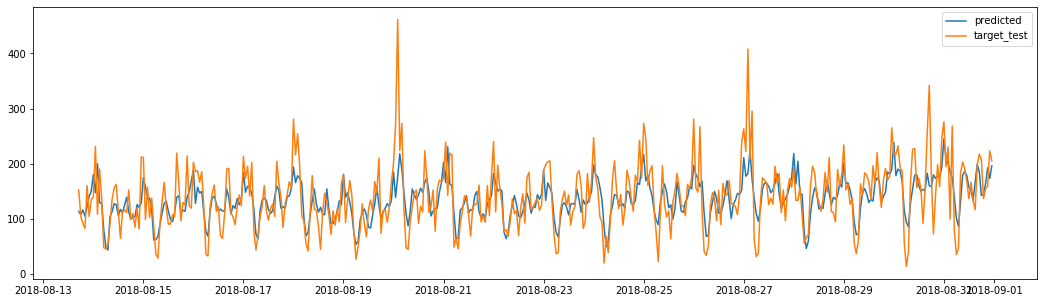

In [113]:
df_mod = features_define(df, shift_best, rolling_best)
df_mod = df_mod.dropna()
train, test = train_test_split(df_mod, shuffle=False, test_size=0.1)

# разделим переменные
target_train = train['num_orders']
target_test = test['num_orders']
features_train = train.drop('num_orders', axis=1)
features_test = test.drop('num_orders', axis=1)

# оценим модель     
model = LinearRegression()
model.fit(features_train, target_train)
predicted = pd.Series(model.predict(features_test))
predicted.index = target_test.index
mse = mean_squared_error(target_test, predicted)
rmse = mse ** 0.5
print(f'shift = {shift_best}, rolling_mean_size = {rolling_best}, rmse:{rmse:.2f}')
plt.figure(figsize=(18,5))
plt.plot(predicted)
plt.plot(target_test)
plt.legend(['predicted', 'target_test'])
plt.show()

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48